# Customer Churn Prediction

Note that, as we do not have a distinct churn value for our customers, the retention rate is at such a low value and we are missing datapoints, there is no real way to predict customer churning for this set of data. However in the following I will show a small bit of code to build a simple model to predict churn.

In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import datetime
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture
import xgboost as xgb

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 400)

In [3]:
df = pd.read_pickle("./Data/clv2u.pickle")

#### Build churn values for customers based on the data we have

In [4]:
#lets say that if the prediction for a future buy is bigger than 1 the customer has churn of no(0), else yes(1)
def churnfunc(value):
    return 0 if value >= 1 else 1
df["churn"] = df.predicted_purchases_oneyear.apply(churnfunc)

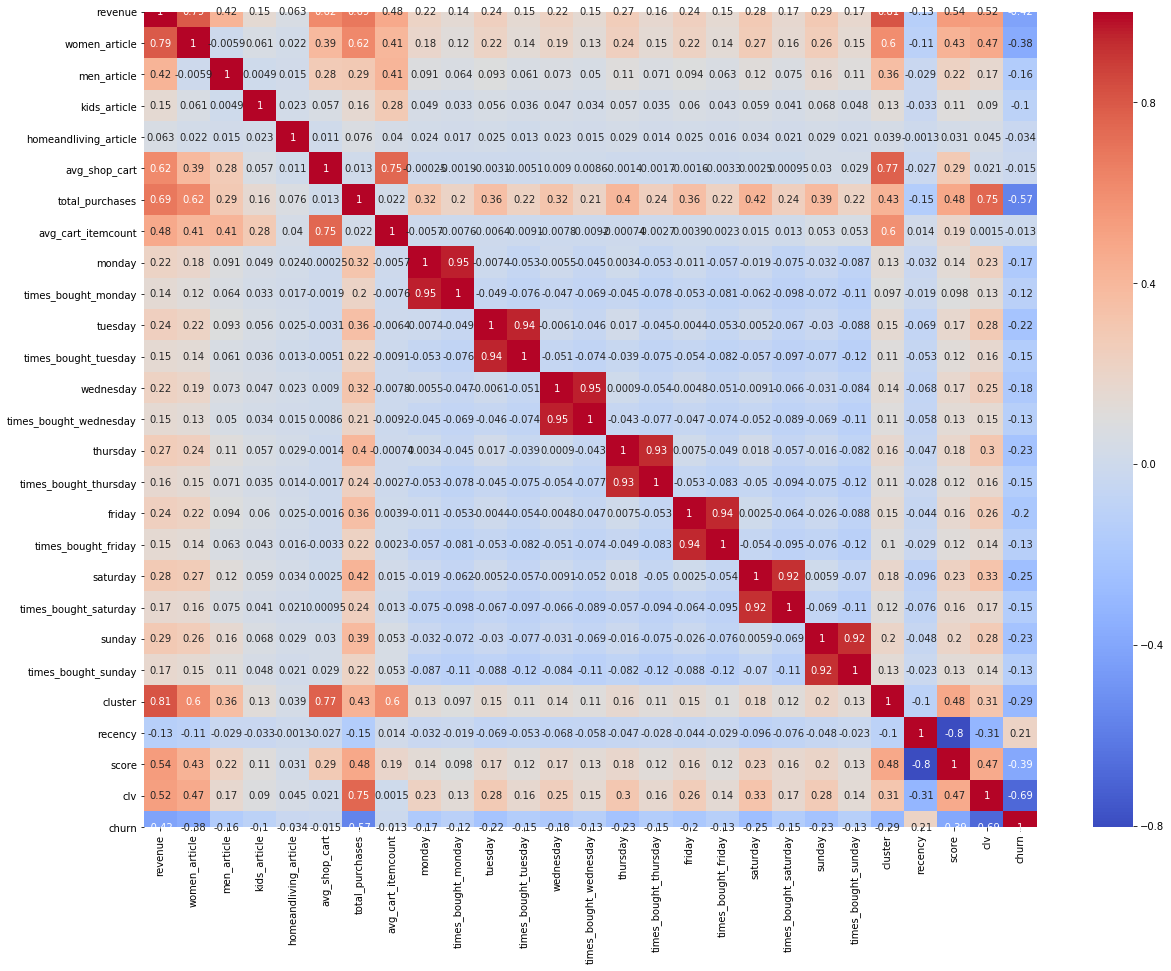

In [7]:
# with the heatmap check if churn is correlation heavily with some feature
X_heat = df.drop(['user_id', 'country', 'region', 'city',"predicted_purchases_oneyear", "frequency"],axis=1)
plt.figure(figsize = (20,15))
sns.heatmap(X_heat.corr(), annot=True, cmap = 'coolwarm')

In [8]:
X = df.drop(['churn','user_id', 'country', 'region', 'city',"predicted_purchases_oneyear", "frequency"],axis=1)
y = df.churn

In [9]:
X = pd.get_dummies(X)

In [10]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=56)
#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective='binary:logistic', n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 1.00


In [11]:
#predict test set
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1570
           1       1.00      1.00      1.00     60692

    accuracy                           1.00     62262
   macro avg       0.98      0.99      0.98     62262
weighted avg       1.00      1.00      1.00     62262



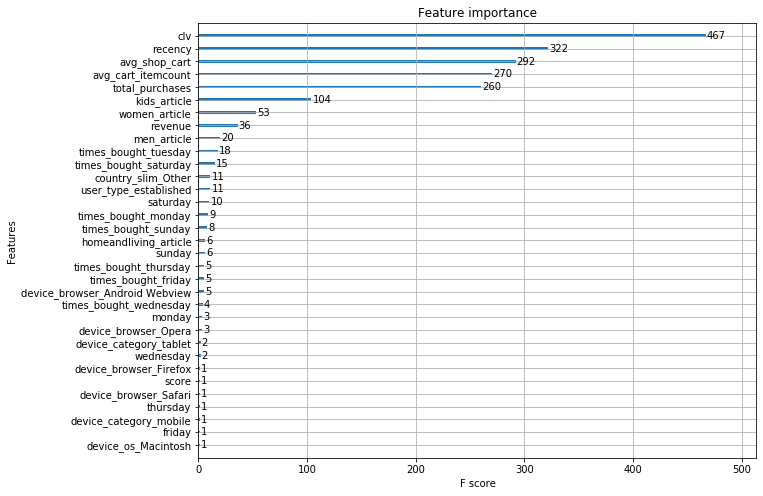

In [12]:
#get feature importance
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

Get the probability for a customer to churn and add it to the data.

In [13]:
X['churn_prob'] = xgb_model.predict_proba(X)[:,1]

In [14]:
plc = X["churn_prob"]

In [15]:
df_churn = df.join(plc)

In [16]:
df_churn.to_pickle("Data/churn.pickle")

In [24]:
df_churn.sample(5)

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim,cluster,recency,frequency,score,value_segment,predicted_purchases_oneyear,clv,churn,churn_prob
319482,466983,44.70,1,0,0,0,44.70,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,first,Germany,Bavaria,Schwabach,desktop,Firefox,Windows,Germany,0,438,1,0,low,0.05,1.33,1,0.999835
431182,19737,184.41,6,0,0,0,61.47,3,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,established,Germany,Berlin,Berlin,mobile,Safari,iOS,Germany,1,98,3,3,mid,0.75,21.01,1,0.997225
147825,215893,16.80,0,1,0,0,16.80,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Nordenham,desktop,Firefox,Windows,Germany,0,235,1,1,low,0.08,2.17,1,0.999835
48147,70269,19.37,0,0,2,0,19.37,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Austria,Vienna,Vienna,mobile,Safari,iOS,Austria,0,399,1,0,low,0.05,1.44,1,0.999835
308949,451663,75.59,4,0,0,0,75.59,1,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Hamburg,Hamburg,desktop,Firefox,Windows,Germany,0,10,1,2,low,0.34,9.66,1,0.999835


# Conculsion

The code and model work and we do get certain results. But there are obvious flaws, see below at Future Work.

# Future Work

As already mentioned at the beginning of the notebook we lack real churn data. If it would be present it would be possible to get coherent results. As it stands now the predicted churn is meaningless. Also with real data it would be possible to further finetune the XGB model with a GridSearch.